# Two Sector Hank (Formal and Informal With Labor Mobility)
There is a continuum of ex-ante identical households. Each agent can be either employed in the formal ($f$) or informal ($i$) sector. Based on a transition matrix, the agent can switch between sectors.

The Markov transition matrix:

\begin{align*}
    \begin{pmatrix}
        \zeta_f & 1 - \zeta_f \\
        1 - \zeta_i & \zeta_i
    \end{pmatrix}
\end{align*}

This Transition matrix also decides the size of each sector:
In Steady-State, the flows from Sector 1 to Sector 2 and vice versa have to be identical. Denoting sie of each sector $s_i$, we have
\begin{align*}
    s_f * 1 - \zeta_f &= s_i * 1 - \zeta_i \\
    \frac{s_f}{s_i} &=\frac{1 - \zeta_i}{1 - \zeta_f}
\end{align*}

When we want the formal sector to be half the size of the informal sector and we know the flow rate of informal to formal is 0.2:
\begin{align*}
    \frac{1}{2} &=\frac{0.2}{1 - \zeta_f} \\
    1 - \zeta_f &= 0.4
\end{align*}


Formal and informal sector differ in the following aspects:
1. Only the formal type can be taxed by the government.
2. There is a wage gap between formal and informal sector
3. Workers in the informal sector get no unemployment insurance
4. Workers in the informal sector have a higher risk of unemployment.

Lastly, we need to divide total GDP as labor income to both groups.
Disposable income ($Z$) is a function of output ($Y$), wage ratio ($w$), size of formal sector ($s_f$) and taxes ($T$):
\begin{align*}
Z &= Y - T \\
Z^f &= (Y * w) - (T /s_f) \\
Z^i &= Y / w
\end{align*}

Note that we scale the taxes by the size of the sector as workers in the formal sector have to pay all taxes.

When linerarizing the model, we will have a change in Y and T. I do the following:



\begin{align*}
    \Delta Z^f &= \Delta Y - \Delta T /s_f \\
    \Delta Z^i &= \Delta Y
\end{align*}

In [1]:
from TwoSectorModel_HANK import TwoSectorMarkovConsumerType
import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc
from sequence_jacobian.classes import JacobianDict, SteadyStateDict
from sequence_jacobian import het, simple, create_model              # functions
import matplotlib.pyplot as plt
import numpy as np
import time
from copy import copy, deepcopy

from scipy import optimize

In [2]:
def show_irfs(irfs_list, variables, labels=[" "], ylabel=r"Percentage points (dev. from ss)", T_plot=50, figsize=(18, 6)):
    if len(irfs_list) != len(labels):
        labels = [" "] * len(irfs_list)
    n_var = len(variables)
    fig, ax = plt.subplots(1, n_var, figsize=figsize, sharex=True)
    for i in range(n_var):
        # plot all irfs
        for j, irf in enumerate(irfs_list):
            ax[i].plot(100 * irf[variables[i]][:50], label=labels[j])
        ax[i].set_title(variables[i])
        ax[i].set_xlabel(r"$t$")
        if i==0:
            ax[i].set_ylabel(ylabel)
        ax[i].legend()
    plt.show()

### 1) Prepare the Agent in HARK

In [3]:
# Define the Markov transition matrix for sector f(ormal) to i(nformal). The ratio of the flow probabioities defines the size of the sector.
p_f_to_i = 0.2
p_i_to_f = 0.2
p_f_to_f = 1 - p_f_to_i
p_i_to_i = 1 - p_i_to_f

MrkvArray = np.array(
    [
        [
            p_f_to_f
        ,
            p_f_to_i
        ],
        [
           p_i_to_f
        ,
            p_i_to_i
        ]
    ]
)

NSectors = 2

## Size of the formal sector (sf); the relative size (sf_share) and wage share (wage_share) which is the ratio between wages in the sectors.
sf_share = (p_i_to_f) / ( p_f_to_i)
sf = sf_share/(1+sf_share)
wage_share = 1.3

print("Relative Size of Formal Sector: ", sf_share)
print("Size Formal Sector: ", sf)

Relative Size of Formal Sector:  1.0
Size Formal Sector:  0.5


In [4]:
# Defining microeconomic parameters
cycles = 0          # 0 means infinite horizon
T_cycles = 1        # Number of cycles to simulate
T = 300             # Dimention of TxT Jacobian matrix

# Parameters which are the same for all agents (Could be different for different agents)
LivPrb = .99375     # Probability of surviving 
PermShkStd = 0.06   # Standard deviation of log permanent income shocks
TranShkStd = 0.2    # Standard deviation of log transitory income shocks
PermGroFac = 1.0    # Permanent income growth factor
BoroCnstArt = 0.0   # Artificial borrowing constraint; imposed minimum level of end-of period assets

# Parameters which are different for formal and informal sector agents
UnempPrb_i = 0.1
IncUnemp_i = 0.00
UnempPrb_f = 0.05
IncUnemp_f = 0.7

In [5]:
# Defining steady state values of the economy
r_ss = 1.03 - 1
G_ss = .2
B_ss = 0.7 #0.25 # this is lower than the tutorial by Straub et al. because need Higher MPC
Y_ss = 1.0

# Calculate steady state value of Taxes (T)
def fiscal_ss(B, r, G): 
    T = (1 + r) * B + G - B + (UnempPrb_f * IncUnemp_f) *sf # Unemployment insurance which needs to be paid by the government   
    return T

T_ss = fiscal_ss(B_ss,r_ss,G_ss)
print('T_ss: ' +str(T_ss))

# Calculate disposable income of each sector
Zf_ss = (Y_ss * wage_share) - (T_ss/ sf) # Only formal sector can be taxed
Zi_ss = (Y_ss /wage_share)

# Calculate steady state value of Consumption
C_ss = Y_ss - G_ss

print('Zf_ss: ' +str(Zf_ss))
print('Zi_ss: ' +str(Zi_ss))
print('C_ss: ' +str(Y_ss - G_ss))


T_ss: 0.23850000000000007
Zf_ss: 0.823
Zi_ss: 0.7692307692307692
C_ss: 0.8


In [6]:
### Create Dictionary
init_twosector = {
    "cycles" : cycles,
    "T_cycle" : T_cycles,
    # Parameters shared with the perfect foresight model
    "DiscFac": 0.9455718034241029,
    "Rfree": [np.array(2 * [1.03])] * T_cycles, #np.array(2 * [1.0 + r_ss]),                   # Interest factor on assets

    ### Two Sector Model Parameters
    "PermShkStd": [np.array([PermShkStd, PermShkStd])] * T_cycles,  # Standard deviation of log permanent shocks to income for each sector
    "TranShkStd": [np.array([TranShkStd, TranShkStd])] * T_cycles,  # Standard deviation of log transitory shocks to income for each sector
    "UnempPrb": [np.array([UnempPrb_f, UnempPrb_i])] * T_cycles,  # Probability of unemployment while working for each sector
    "IncUnemp": [np.array([IncUnemp_f, IncUnemp_i])] * T_cycles,  # Unemployment benefits replacement rate for each sector
    "taxrate": [np.array([0, 0])] * T_cycles,  # Tax Rate for each sector
    "labor": [np.array([Zf_ss, Zi_ss])] * T_cycles,  # Labor for each sector
    "wage": [np.array([1, 1])] * T_cycles,  # Wage for each sector
    "BoroCnstArt": [BoroCnstArt, BoroCnstArt],  # Borrowing constraint for the minimum allowable assets to end the period with  
    "LivPrb": [np.array([LivPrb, LivPrb])] * T_cycles,
    "PermGroFac": [np.array([PermGroFac, PermGroFac])] * T_cycles,
    # Parameters that specify the income distribution over the lifecycle
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkCount" : 5,    
    
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 100,                     # Number of points in the base grid of "assets above minimum"
    
    # Transition Matrix simulation parameters
    "mCount": 200,
    "mMax": 500,
    "mMin": 1e-5,
    "mFac": 3,

    # Hank model bool
    "HANK":True,     
    
     ### Markov Parameters
    "MrkvArray": [MrkvArray] * T_cycles,  # Transition Matrix for Markov Process
    "global_markov": False,  # If True, then the Markov Process is the same for all agents
    "MrkvPrbsInit": [sf, 1 - sf],

}


# to add taxes, labor, and wage. This ensures that we can shock each variable.
def function(taxrate, labor, wage):
    z = (1- taxrate)*labor*wage
    
    return z

init_twosector['TranShkMean_Func'] = [function]

### Calibrating Discount Factor to assumer household assets equal government bonds

In [7]:
### Target Steady State Asset
def ss_func(beta):
    init_twosector['DiscFac'] = beta
    Agent_func = TwoSectorMarkovConsumerType(**init_twosector, verbose = False)
    A_ss = Agent_func.compute_steady_state()[0] ## Steady state value of Assets
    return A_ss
    

def ss_dif(beta):  
    difference = ss_func(beta) - Asset_target 
    return difference

Asset_target = B_ss
DiscFac = optimize.brentq(ss_dif,.2,.95)
print(DiscFac)

c:\Users\adria\anaconda3\envs\Durable\lib\site-packages\HARK\interpolation.py:2187: RuntimeWarning: All-NaN slice encountered
c:\Users\adria\anaconda3\envs\Durable\lib\site-packages\HARK\interpolation.py:2187: RuntimeWarning: All-NaN slice encountered


0.8955213278320708


### Initiate Agent type with calibrated Discount Factor

In [8]:
# init_twosector_life['DiscFac'] = DiscFac
init_twosector['DiscFac'] = DiscFac
Agent_GE = TwoSectorMarkovConsumerType(**init_twosector)
Agent_GE.solve()

In [9]:
A_ss, C_ss, A_ss_Markv, C_ss_Markv = Agent_GE.compute_steady_state()
print(A_ss, C_ss)

0.7000000000010325 0.8140446723034713


In [10]:
print(A_ss_Markv, C_ss_Markv)

[0.66810334 0.73189666] [0.84303808 0.78505126]


Informal sector has slightly higher savings due to higher risk, but formal sector workers consume more on average.

In [11]:
### Plot Consumption Functions
mGrid = np.linspace(0, 4, 200)
mGrid = mGrid - 2

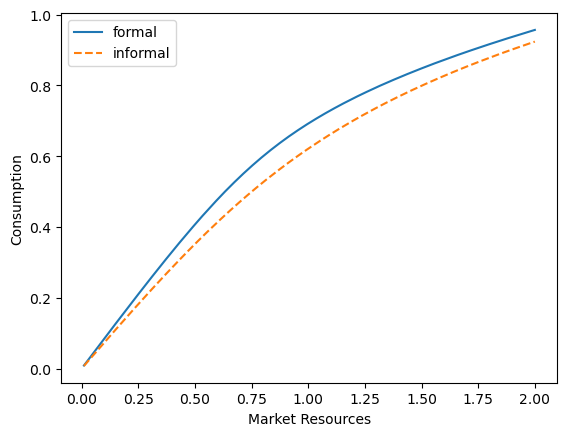

In [12]:
plt.plot(mGrid, Agent_GE.solution[0].cFunc[0](mGrid), label = 'formal')
plt.plot(mGrid, Agent_GE.solution[0].cFunc[1](mGrid), '--', label = 'informal')
plt.ylabel("Consumption")
plt.xlabel("Market Resources")
plt.legend()

#### Calculate Jacobians
We can calculate Jacobians based on a shock which affects both types (0), type 1 (1), or type (2).

In [13]:
# Parameter changes for both types
start = time.time()

CJACR, AJACR = Agent_GE.calc_jacobian('Rfree', 0, T)
CJACZ, AJACZ = Agent_GE.calc_jacobian('labor', 0, T)

print('Seconds to calculate Jacobian', time.time() - start)

Seconds to calculate Jacobian 13.14916706085205


In [14]:
### Parameter changes for only one agent
start = time.time()

CJACR_f, AJACR_f = Agent_GE.calc_jacobian('Rfree', 1, T)
CJACZ_f, AJACZ_f = Agent_GE.calc_jacobian('labor', 1, T)

CJACR_i, AJACR_i = Agent_GE.calc_jacobian('Rfree', 2, T)
CJACZ_i, AJACZ_i = Agent_GE.calc_jacobian('labor', 2, T)
print('Seconds to calculate Jacobian', time.time() - start)


Seconds to calculate Jacobian 26.053351402282715


Let's plot them

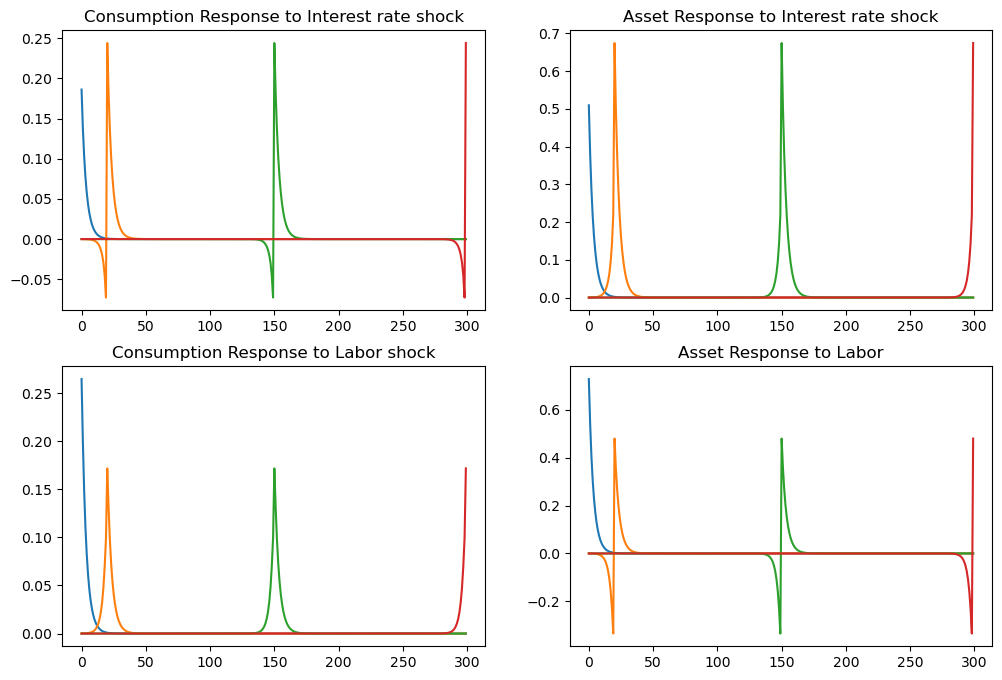

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Consumption Response to Interest rate shock
axs[0, 0].plot(CJACR.T[0])
axs[0, 0].plot(CJACR.T[20])
axs[0, 0].plot(CJACR.T[150])
axs[0, 0].plot(CJACR.T[-1])
axs[0, 0].set_title("Consumption Response to Interest rate shock")

# Asset Response to Interest rate shock
axs[0, 1].plot(AJACR.T[0])
axs[0, 1].plot(AJACR.T[20])
axs[0, 1].plot(AJACR.T[150])
axs[0, 1].plot(AJACR.T[-1])
axs[0, 1].set_title("Asset Response to Interest rate shock")

# Consumption Response to Labor shock
axs[1, 0].plot(CJACZ.T[0])
axs[1, 0].plot(CJACZ.T[20])
axs[1, 0].plot(CJACZ.T[150])
axs[1, 0].plot(CJACZ.T[-1])
axs[1, 0].set_title("Consumption Response to Labor shock")

# Asset Response to Labor
axs[1, 1].plot(AJACZ.T[0])
axs[1, 1].plot(AJACZ.T[20])
axs[1, 1].plot(AJACZ.T[150])
axs[1, 1].plot(AJACZ.T[-1])
axs[1, 1].set_title("Asset Response to Labor")

plt.show()

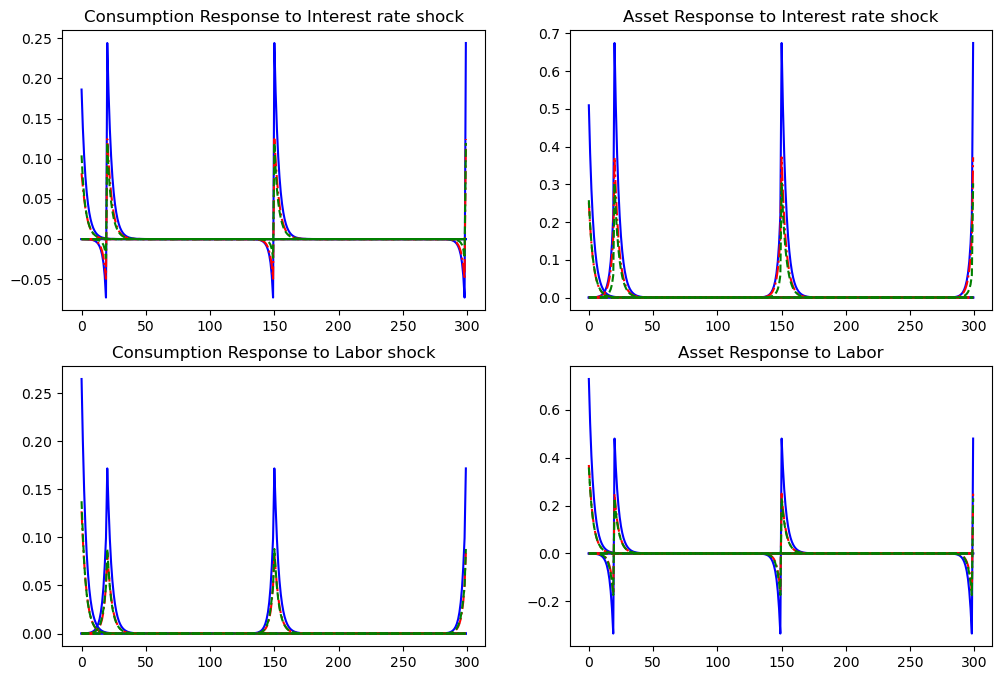

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Consumption Response to Interest rate shock
axs[0, 0].plot(CJACR.T[0], color = 'blue')
axs[0, 0].plot(CJACR.T[20], color = 'blue')
axs[0, 0].plot(CJACR.T[150], color = 'blue')
axs[0, 0].plot(CJACR.T[-1], color = 'blue')
axs[0, 0].plot(CJACR_f.T[0], '-.', color = 'red', label = 'formal')
axs[0, 0].plot(CJACR_f.T[20], '-.', color = 'red', label = 'formal')
axs[0, 0].plot(CJACR_f.T[150], '-.', color = 'red', label = 'formal')
axs[0, 0].plot(CJACR_f.T[-1], '-.', color = 'red', label = 'formal')
axs[0, 0].plot(CJACR_i.T[0], '--', color = 'green', label = 'informal')
axs[0, 0].plot(CJACR_i.T[20], '--', color = 'green', label = 'informal')
axs[0, 0].plot(CJACR_i.T[150], '--', color = 'green', label = 'informal')
axs[0, 0].plot(CJACR_i.T[-1], '--', color = 'green', label = 'informal')
axs[0, 0].set_title("Consumption Response to Interest rate shock")

# Asset Response to Interest rate shock
axs[0, 1].plot(AJACR.T[0], color = 'blue')
axs[0, 1].plot(AJACR.T[20], color = 'blue')
axs[0, 1].plot(AJACR.T[150], color = 'blue')
axs[0, 1].plot(AJACR.T[-1], color = 'blue')
axs[0, 1].plot(AJACR_f.T[0], '-.', color = 'red', label = 'formal')
axs[0, 1].plot(AJACR_f.T[20], '-.', color = 'red', label = 'formal')
axs[0, 1].plot(AJACR_f.T[150], '-.', color = 'red', label = 'formal')
axs[0, 1].plot(AJACR_f.T[-1], '-.', color = 'red', label = 'formal')
axs[0, 1].plot(AJACR_i.T[0], '--', color = 'green', label = 'informal')
axs[0, 1].plot(AJACR_i.T[20], '--', color = 'green', label = 'informal')
axs[0, 1].plot(AJACR_i.T[150], '--', color = 'green', label = 'informal')
axs[0, 1].plot(AJACR_i.T[-1], '--', color = 'green', label = 'informal')
axs[0, 1].set_title("Asset Response to Interest rate shock")

# Consumption Response to Labor shock
axs[1, 0].plot(CJACZ.T[0], color = 'blue')
axs[1, 0].plot(CJACZ.T[20], color = 'blue')
axs[1, 0].plot(CJACZ.T[150], color = 'blue')
axs[1, 0].plot(CJACZ.T[-1], color = 'blue')
axs[1, 0].plot(CJACZ_f.T[0], '-.', color = 'red', label = 'formal')
axs[1, 0].plot(CJACZ_f.T[20], '-.', color = 'red', label = 'formal')
axs[1, 0].plot(CJACZ_f.T[150], '-.', color = 'red', label = 'formal')
axs[1, 0].plot(CJACZ_f.T[-1], '-.', color = 'red', label = 'formal')
axs[1, 0].plot(CJACZ_i.T[0], '--', color = 'green', label = 'informal')
axs[1, 0].plot(CJACZ_i.T[20], '--', color = 'green', label = 'informal')
axs[1, 0].plot(CJACZ_i.T[150], '--', color = 'green', label = 'informal')
axs[1, 0].plot(CJACZ_i.T[-1], '--', color = 'green', label = 'informal')
axs[1, 0].set_title("Consumption Response to Labor shock")

# Asset Response to Labor
axs[1, 1].plot(AJACZ.T[0], color = 'blue')
axs[1, 1].plot(AJACZ.T[20], color = 'blue')
axs[1, 1].plot(AJACZ.T[150], color = 'blue')
axs[1, 1].plot(AJACZ.T[-1], color = 'blue')
axs[1, 1].plot(AJACZ_f.T[0], '-.', color = 'red', label = 'formal')
axs[1, 1].plot(AJACZ_f.T[20], '-.', color = 'red', label = 'formal')
axs[1, 1].plot(AJACZ_f.T[150], '-.', color = 'red', label = 'formal')
axs[1, 1].plot(AJACZ_f.T[-1], '-.', color = 'red', label = 'formal')
axs[1, 1].plot(AJACZ_i.T[0], '--', color = 'green', label = 'informal')
axs[1, 1].plot(AJACZ_i.T[20], '--', color = 'green', label = 'informal')
axs[1, 1].plot(AJACZ_i.T[150], '--', color = 'green', label = 'informal')
axs[1, 1].plot(AJACZ_i.T[-1], '--', color = 'green', label = 'informal')
axs[1, 1].set_title("Asset Response to Labor")

plt.show()

From this exercise, we can already see the MPC which is the consumption response to a labor shock happening today without anticipation. THis is in the bottom left graph the starting point of the first blue line. The resulting Keynesian Multiplier can be calculated using:
$$
    Multiplier = \frac{1}{1-MPC} 
$$

In [17]:
Multiplier = 1/(1 - CJACZ.T[0][0])
print("MPC in the model is: ", CJACZ.T[0][0])
print("Keynesian Multiplier is: ", Multiplier)

MPC in the model is:  0.26486632929367815
Keynesian Multiplier is:  1.3602968274316596


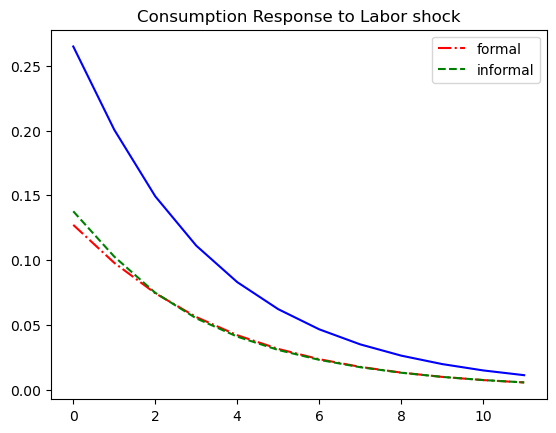

In [18]:
### Plot i-MPC
plt.plot(CJACZ.T[0][:12], color = 'blue')
plt.plot(CJACZ_f.T[0][:12], '-.', color = 'red', label = 'formal')
plt.plot(CJACZ_i.T[0][:12], '--', color = 'green', label = 'informal')
plt.legend()
plt.title("Consumption Response to Labor shock")
plt.show()

### Switch from HARK to SSJ
We're done with the HARK-work and can define dictionaries for Steady State Values and Jacobians

In [19]:
HARK_SteadyState_Dict = SteadyStateDict({"C": C_ss, "r": r_ss, "Y": Y_ss, "B": B_ss, "G": G_ss, "A": A_ss})
HARK_Jacobian_Dict = JacobianDict( { 'C' : {'Zf' : CJACZ_f, 'Zi': CJACZ_i, 'r': CJACR} ,'A' : {'Zf' : AJACZ_f, 'Zi': AJACZ_i, 'r': AJACR}}) 

Define Fiscal Rule and Market Clearing

In [20]:
alpha = 0.1
@sj.simple
def fiscal(B, r, G, Y): 
    T = (1 + r) * B(-1) + G - B # total tax burden
    # Fiscal rule reduce deficit by alpha each period as in Auclert et al (Micro Jumps and Macro Humps)
    T = alpha*(B(-1) - B_ss) + T_ss
    Zf = Y - T/sf       #Need to pay all taxes
    Zi = Y    
    deficit = G - T
    
    return T, Zf, Zi, deficit

@sj.simple
def mkt_clearing(A, B, Y, C, G):
    asset_mkt = A - B
    goods_mkt = C + G - Y
    
    return asset_mkt, goods_mkt

In [21]:
# Create the model and specify attributes
HARK_HANK = create_model([HARK_Jacobian_Dict, fiscal, mkt_clearing], name="HARK_HANK")
unknowns = ['Y']
targets = ['asset_mkt']
exogenous = ['G']

## Fiscal Consolidation with MIT shocks (Reverting to Steady State) [WIP]
Government can reduce deficit by increasing taxes or by decreasing government spending.

Problem: With the new Fiscal Rule, the goods market does not clear

### A) MIT Shocks with low persistence

In [22]:
Low_persistence = 0.8

In [23]:
# First, we analyze a government spending shock.
G_std = -.01
dG_MIT =  G_std * Low_persistence**np.arange(T)

# Government spending shock reduces deficit
dB_MIT = np.cumsum(dG_MIT) * Low_persistence ** np.arange(T)
shocks_G_MIT = {'G': dG_MIT, 'B': dB_MIT}

In [24]:
irfs_G_Low_persistence = HARK_HANK.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_G_MIT)

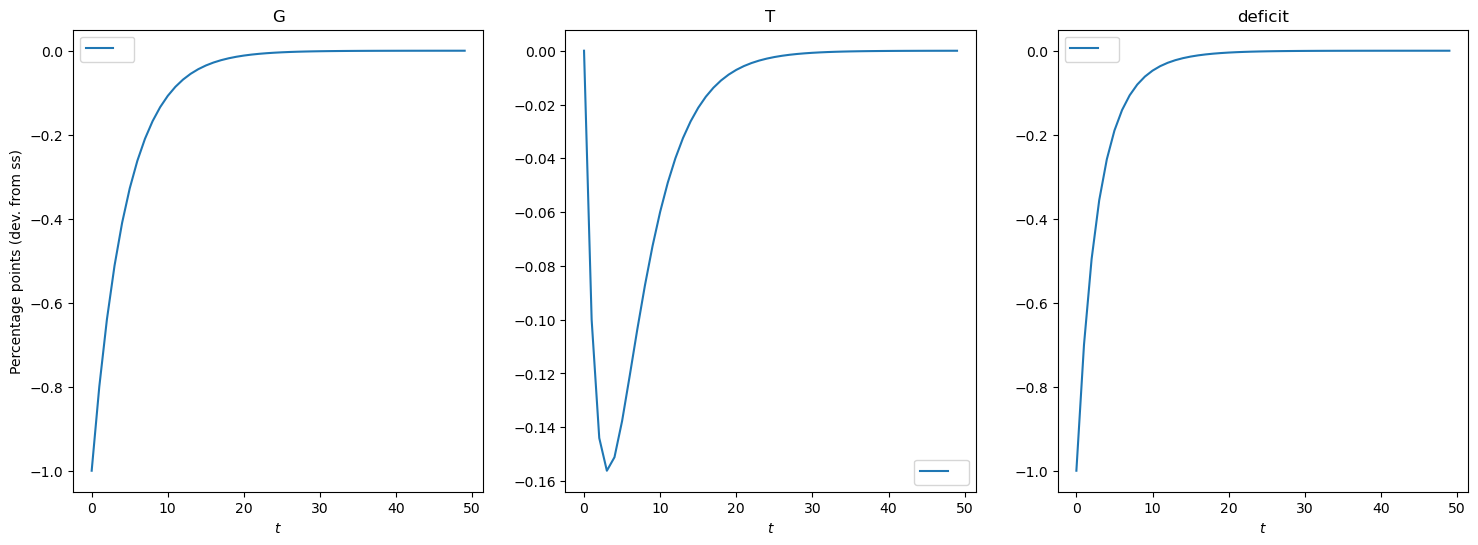

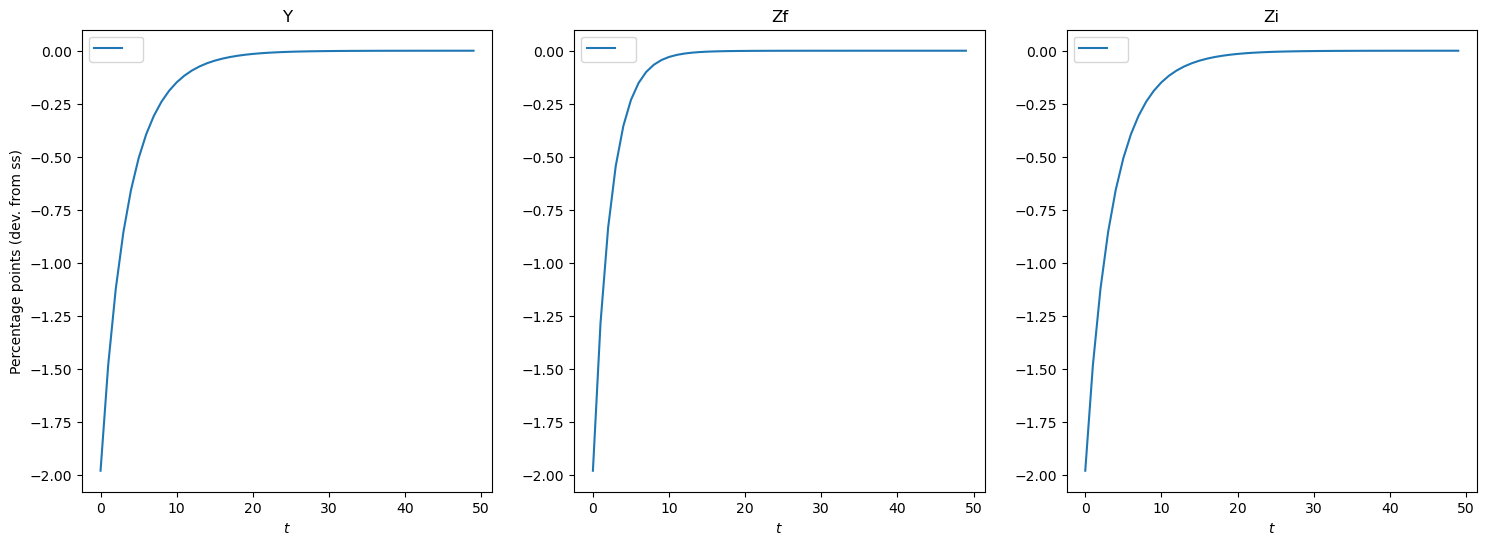

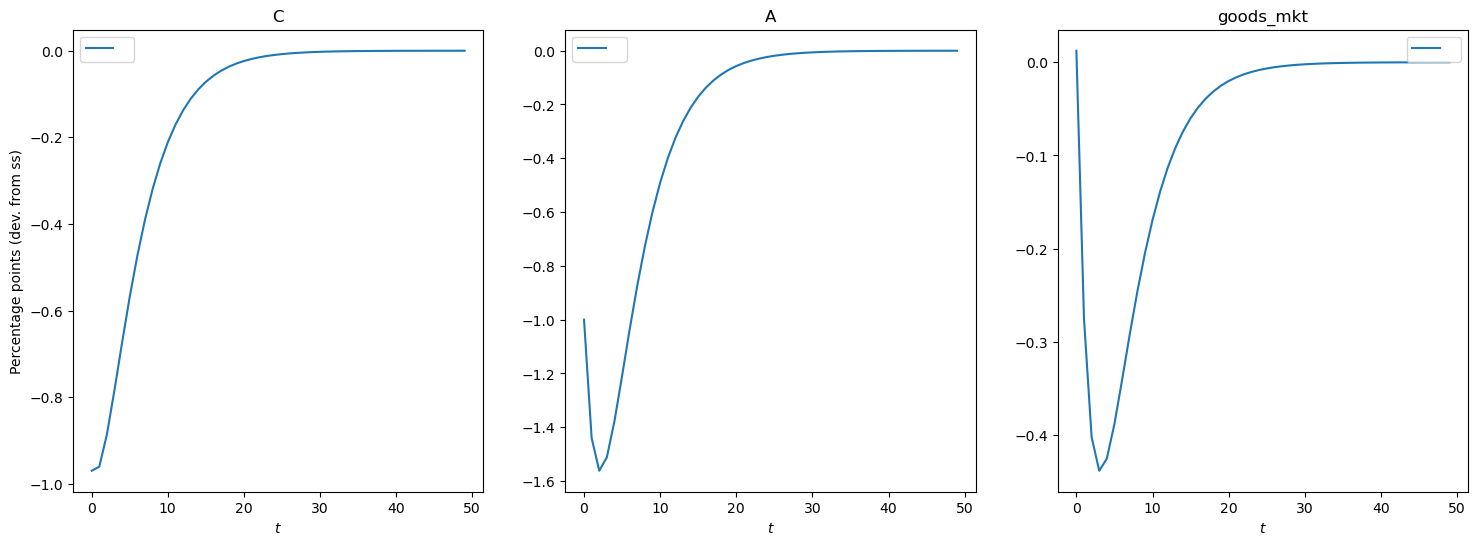

In [25]:
show_irfs([irfs_G_Low_persistence], ['G', 'T', 'deficit'], labels=["Government spending", "Taxes"])
show_irfs([irfs_G_Low_persistence], ['Y', 'Zf', 'Zi'], labels=["Government spending", "Taxes"])
show_irfs([irfs_G_Low_persistence], ['C', 'A', 'goods_mkt'], labels=["Government spending", "Taxes"])

In [26]:
stop

NameError: name 'stop' is not defined

In [ ]:
# First, shock in deficit.
B_std = .001
dB_MIT =  B_std * MIT_persistence**np.arange(T)

# Government spending shock reduces deficit
# dB_MIT = np.cumsum(dG_MIT) * MIT_persistence ** np.arange(T)

# dT_MIT = np.zeros(T)
shocks_B_MIT = {'B': dB_MIT, 'G': -dB_MIT}

In [ ]:
irfs_B_MIT = HARK_HANK.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_B_MIT)

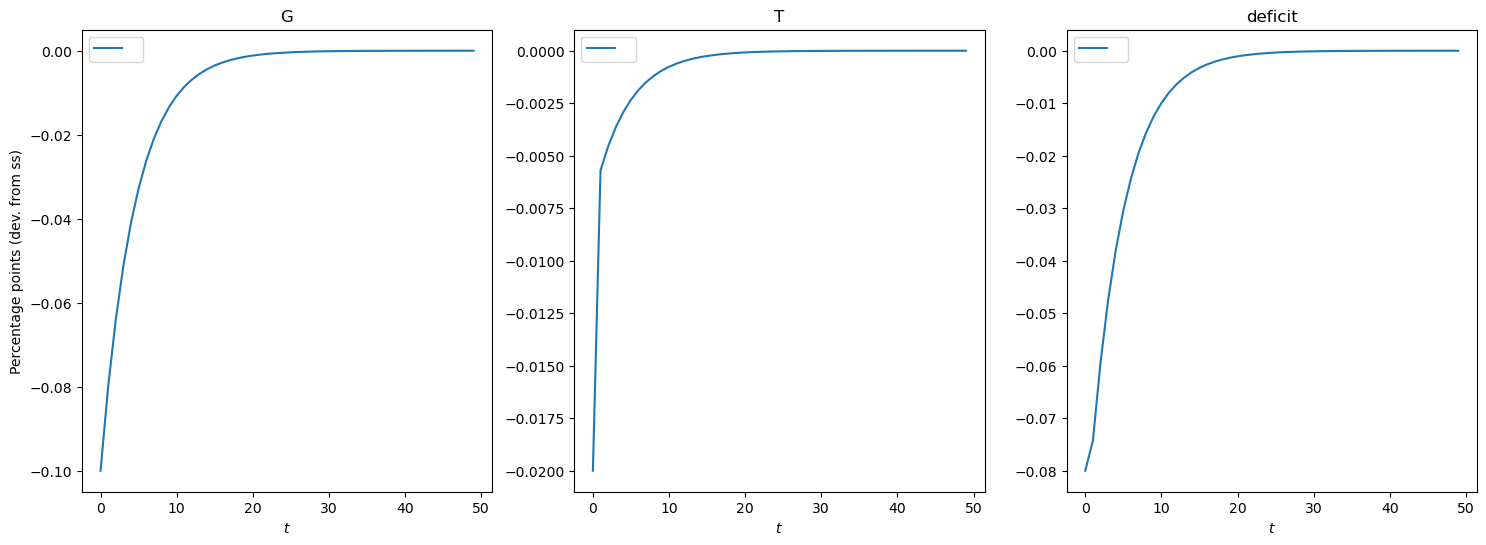

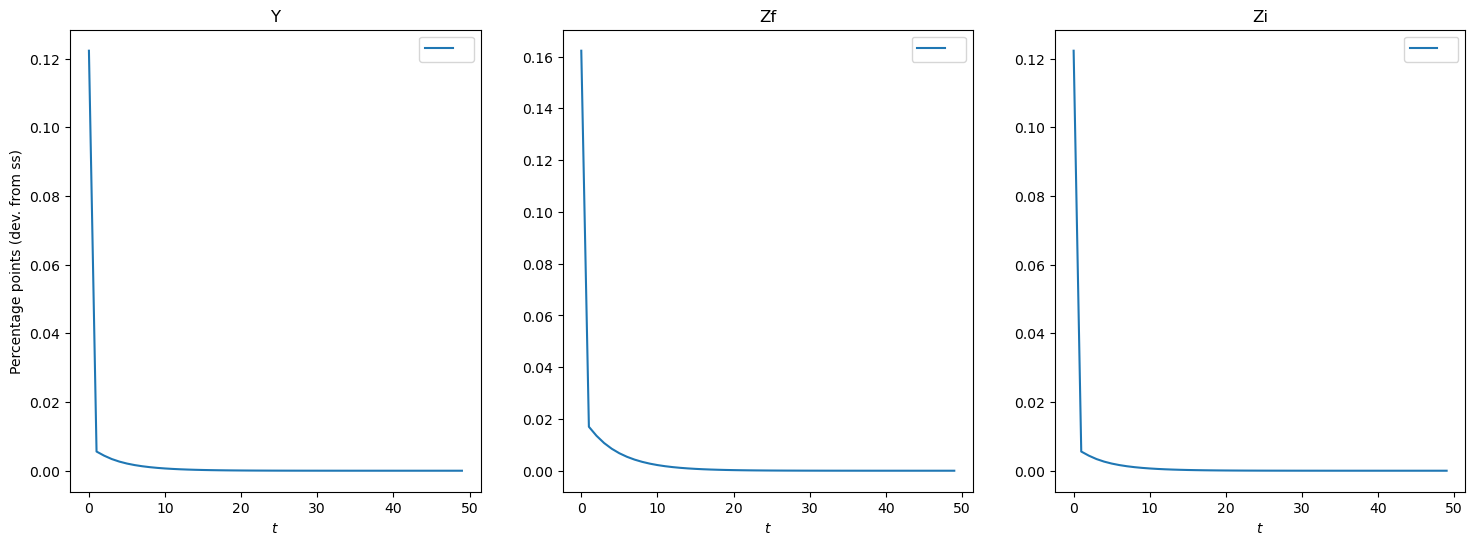

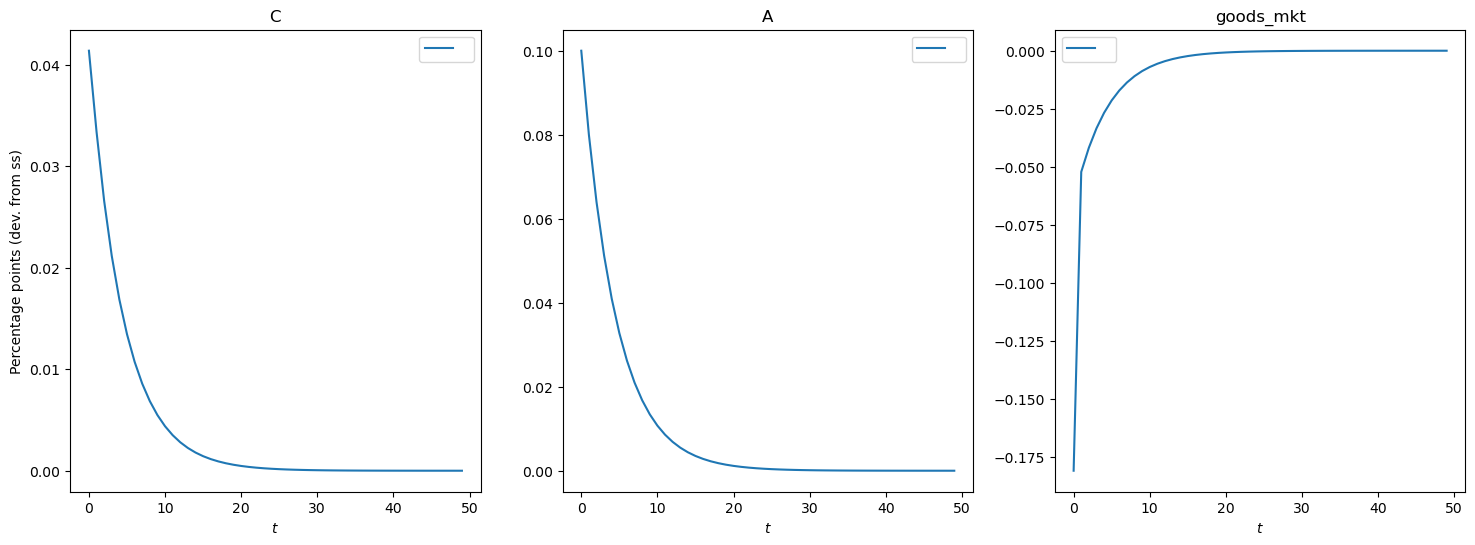

In [ ]:
show_irfs([irfs_B_MIT], ['G', 'T', 'deficit'], labels=["Government spending", "Taxes"])
show_irfs([irfs_B_MIT], ['Y', 'Zf', 'Zi'], labels=["Government spending", "Taxes"])
show_irfs([irfs_B_MIT], ['C', 'A', 'goods_mkt'], labels=["Government spending", "Taxes"])

In [ ]:
# First, we analyze a government spending shock.
G_std = -.001
dG_MIT =  G_std * MIT_persistence**np.arange(T)

# Government spending shock reduces deficit
dB_MIT = np.cumsum(dG_MIT) * MIT_persistence ** np.arange(T)

dT_MIT = np.zeros(T)
shocks_G_MIT = {'G': dG_MIT, 'B': dB_MIT, 'T': dT_MIT}

In [ ]:
irfs_G_MIT = HARK_HANK.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_G_MIT)

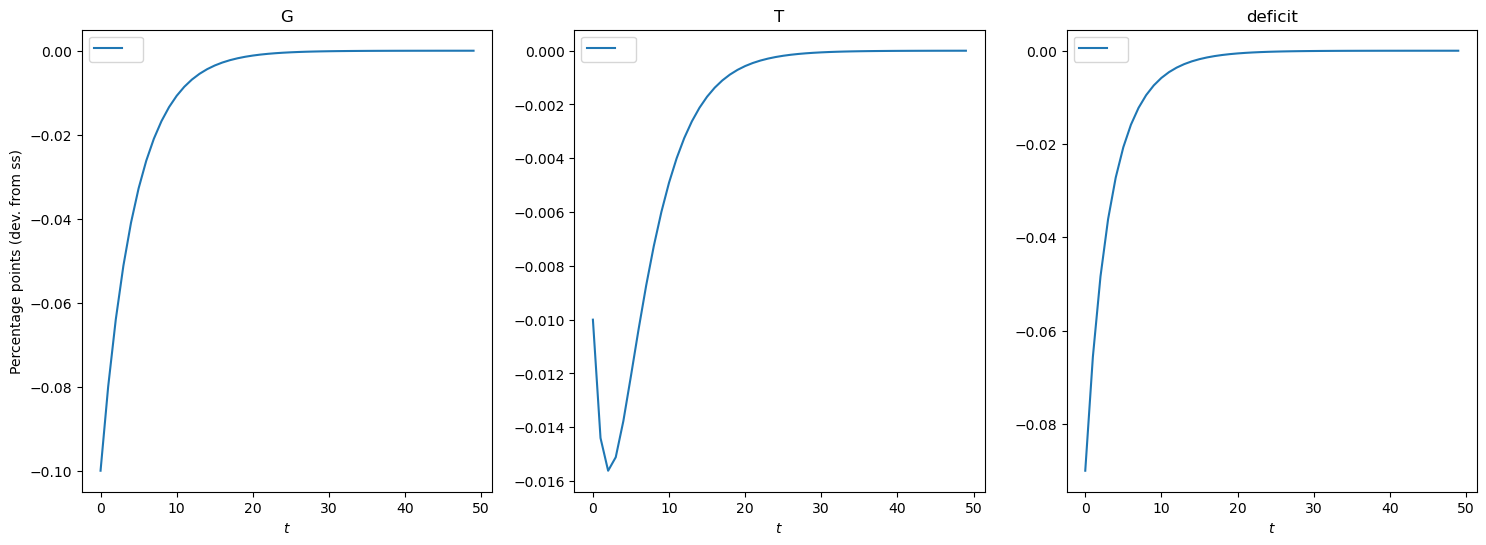

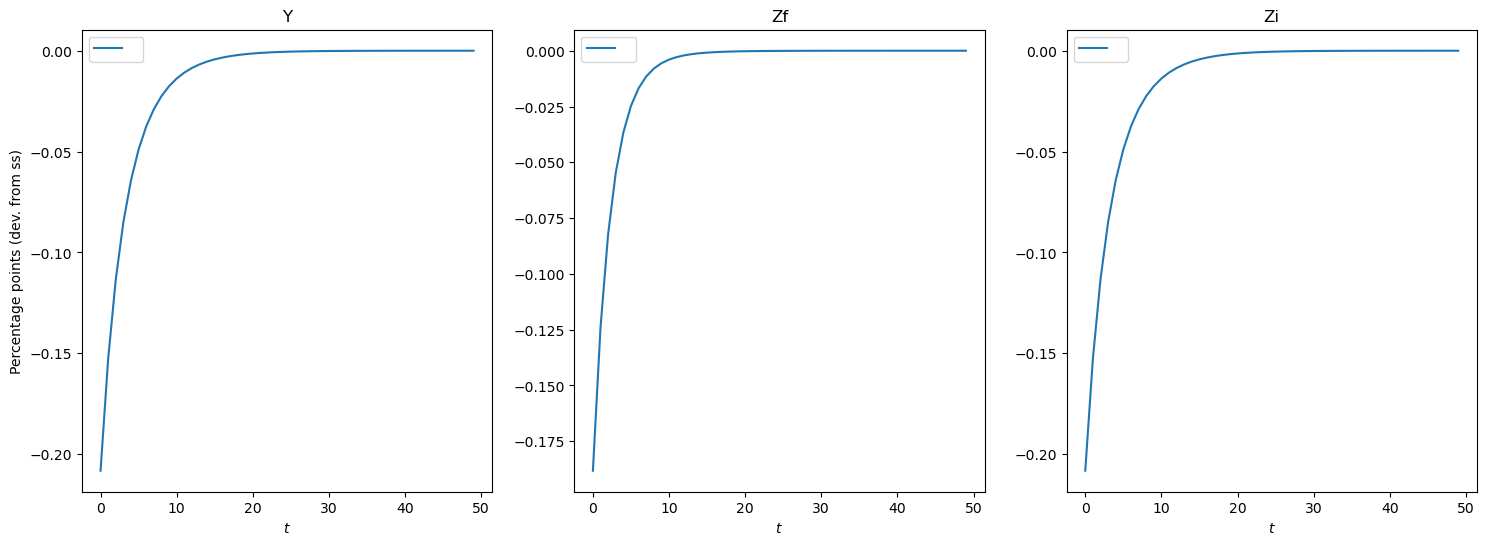

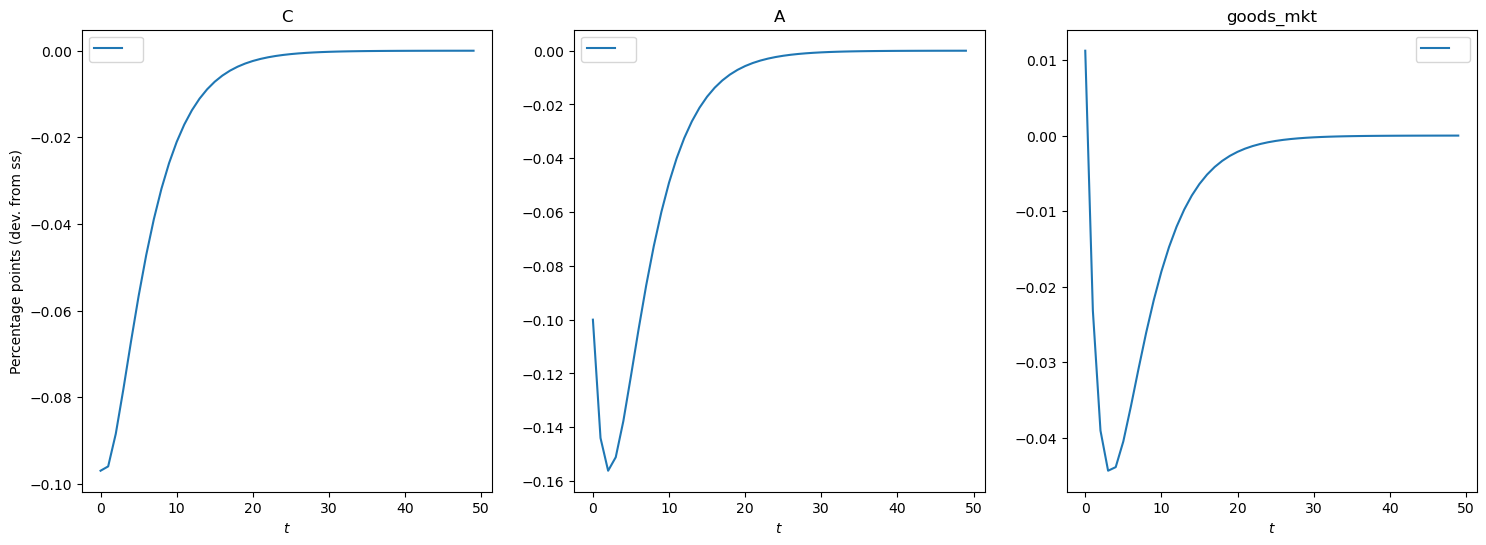

In [ ]:
show_irfs([irfs_G_MIT], ['G', 'T', 'deficit'], labels=["Government spending", "Taxes"])
show_irfs([irfs_G_MIT], ['Y', 'Zf', 'Zi'], labels=["Government spending", "Taxes"])
show_irfs([irfs_G_MIT], ['C', 'A', 'goods_mkt'], labels=["Government spending", "Taxes"])

In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
# Create the model and specify attributes
HARK_HANK = create_model([HARK_Jacobian_Dict, fiscal, mkt_clearing], name="HARK_HANK")
unknowns = ['Y']
targets = ['asset_mkt']
exogenous = ['T']

In [ ]:
# Second, we analyze a tax shock.
T_std = -.01
dT_MIT =  T_std * MIT_persistence**np.arange(T)

# Tax increase reduces deficit
dB_MIT = np.cumsum(dT_MIT) * MIT_persistence ** np.arange(T)

dG_MIT = np.zeros(T)

shocks_T_MIT = {'T': dT_MIT, 'B': dB_MIT, 'G': dG_MIT}

In [ ]:
irfs_T_MIT = HARK_HANK.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_T_MIT)

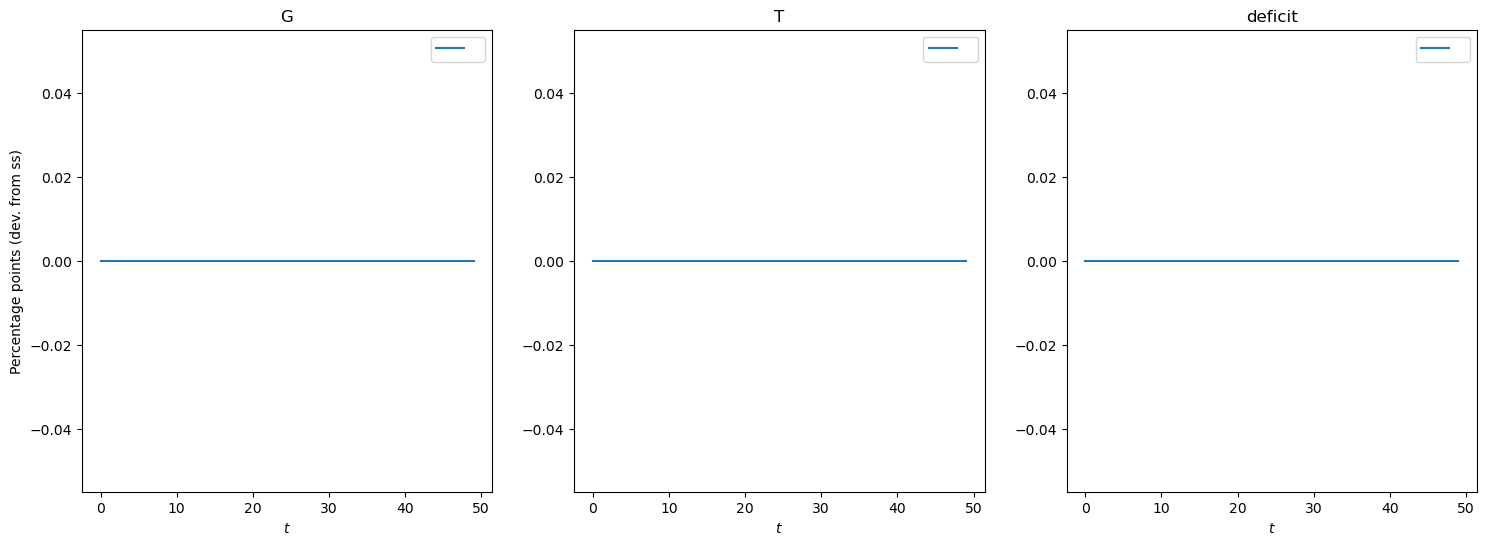

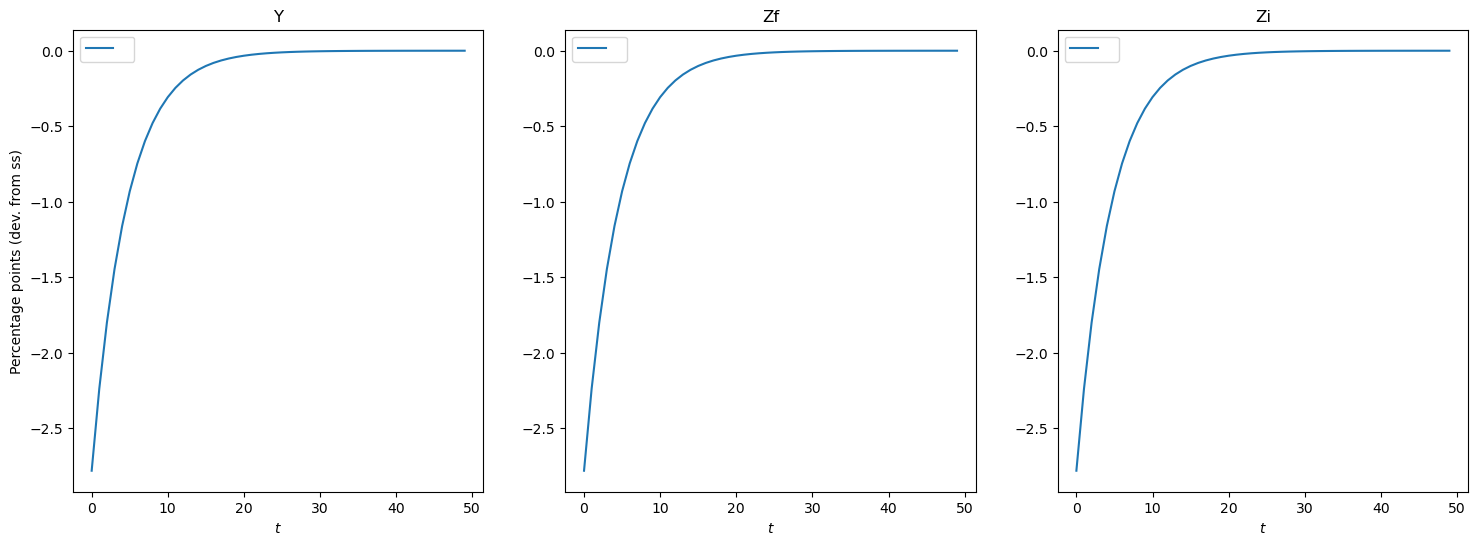

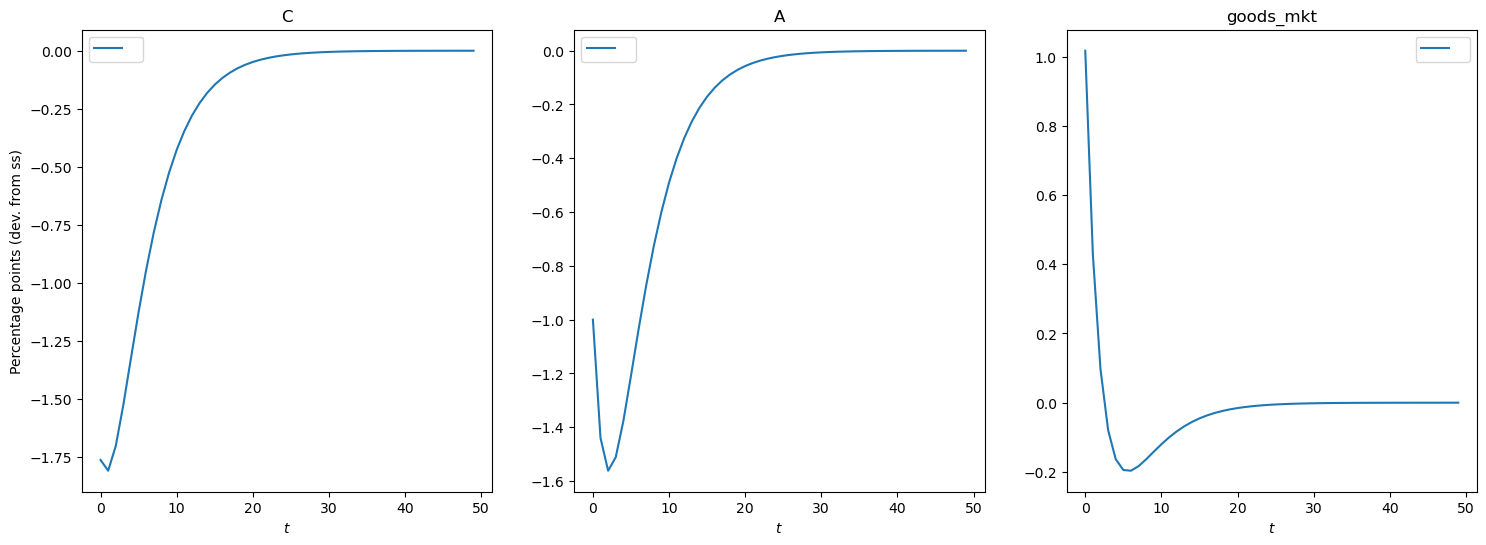

In [ ]:
show_irfs([irfs_T_MIT], ['G', 'T', 'deficit'], labels=["Government spending", "Taxes"])
show_irfs([irfs_T_MIT], ['Y', 'Zf', 'Zi'], labels=["Government spending", "Taxes"])
show_irfs([irfs_T_MIT], ['C', 'A', 'goods_mkt'], labels=["Government spending", "Taxes"])

In [ ]:
# Second, we analyze a tax shock.
B_std = -.01
dB_MIT =  B_std * MIT_persistence**np.arange(T)

# Tax increase reduces deficit
# dB_MIT = np.cumsum(dT_MIT) * MIT_persistence ** np.arange(T)

dG_MIT = np.zeros(T)

shocks_B_MIT = {'B': dB_MIT, 'G': dG_MIT}

In [ ]:
irfs_T_MIT = HARK_HANK.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_B_MIT)

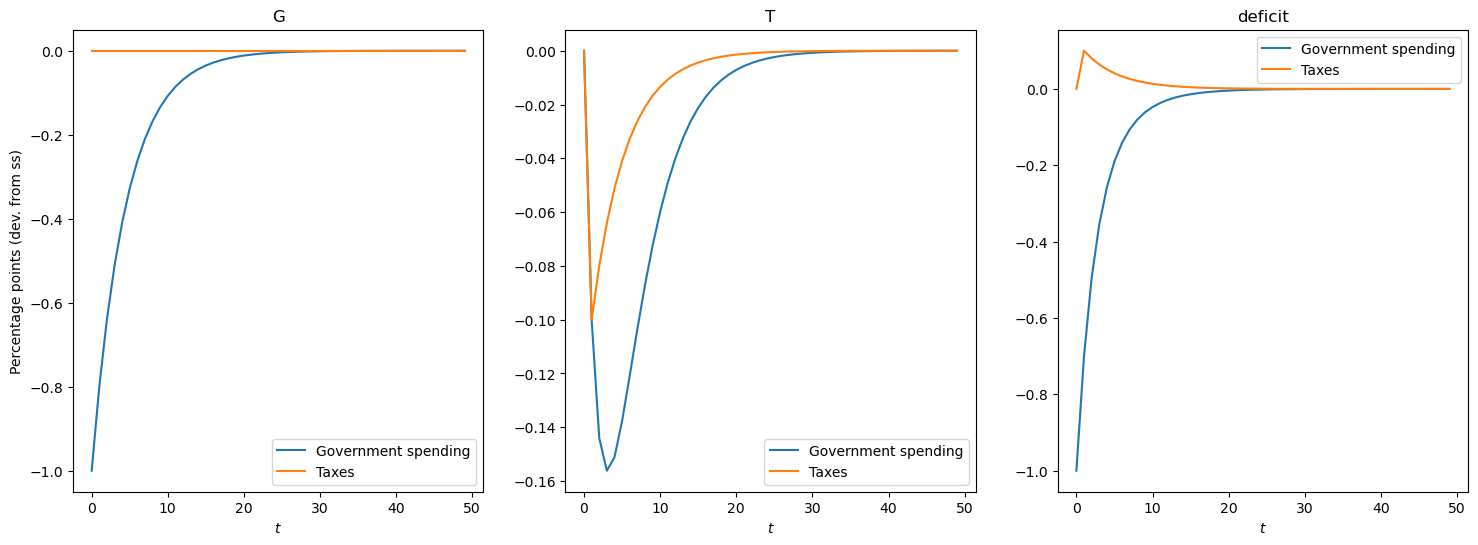

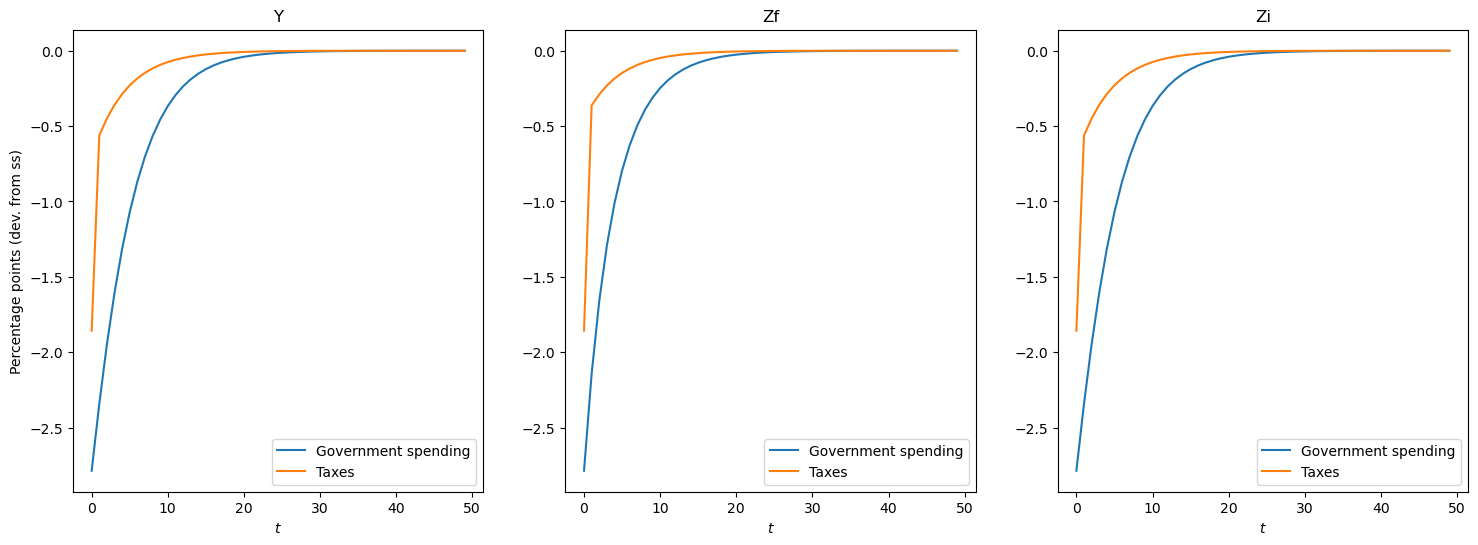

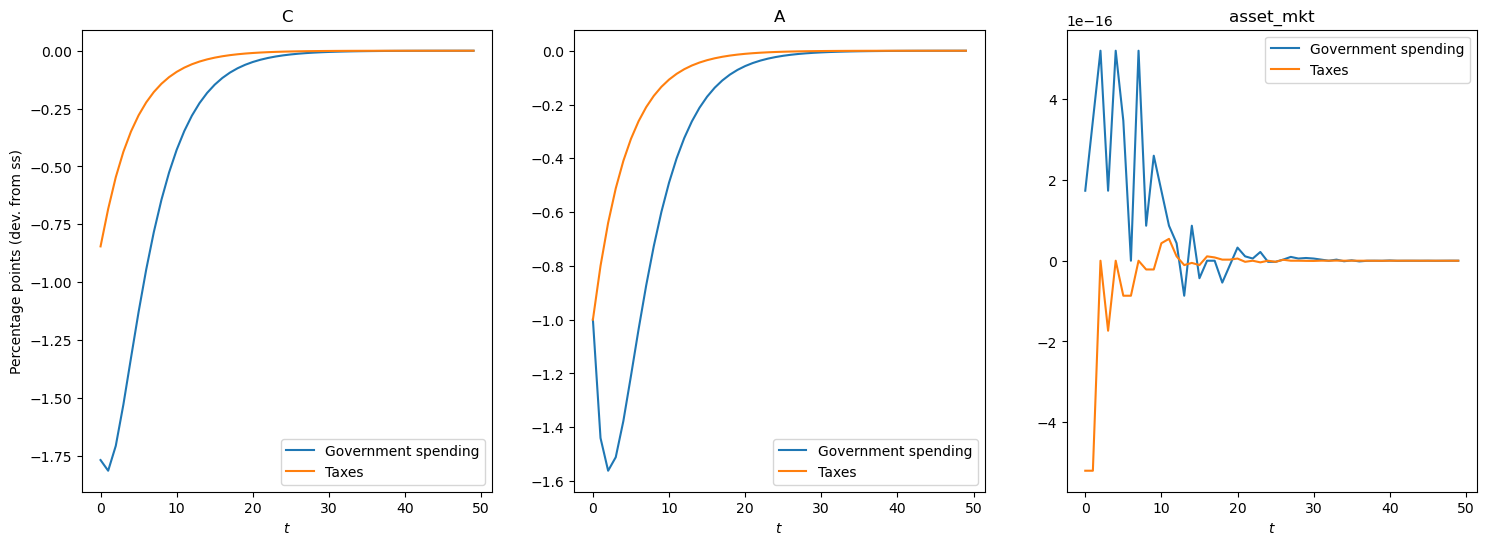

In [ ]:
show_irfs([irfs_B_MIT, irfs_T_MIT], ['G', 'T', 'deficit'], labels=["Government spending", "Taxes"])
show_irfs([irfs_B_MIT, irfs_T_MIT], ['Y', 'Zf', 'Zi'], labels=["Government spending", "Taxes"])
show_irfs([irfs_B_MIT, irfs_T_MIT], ['C', 'A', 'asset_mkt'], labels=["Government spending", "Taxes"])

In [ ]:
stop

### Test with no HH response

In [ ]:
ZeroJac = np.zeros_like(CJACZ_f)

In [ ]:
HARK_Jacobian_ZeroJac_Dict = JacobianDict( { 'C' : {'Zf' : ZeroJac, 'Zi': ZeroJac, 'r': ZeroJac} ,'A' : {'Zf' : ZeroJac, 'Zi': ZeroJac, 'r': ZeroJac}}) 

In [ ]:
# Create the model and specify attributes
HARK_ZeroJac_HANK = create_model([HARK_Jacobian_ZeroJac_Dict, fiscal, mkt_clearing], name="HARK_HANK")
unknowns = ['Y']
targets = ['asset_mkt']
exogenous = ['G']

In [ ]:
irfs_B_MIT = HARK_ZeroJac_HANK.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_B_MIT)

LinAlgError: Singular matrix

### (Semi)-permanent shocks
By increasing the persistence, we have a very long lasting shock.

In [ ]:
Perm_persistence = 0.999

In [ ]:
# First, we analyze a government spending shock.
dG_Perm =  G_std * Perm_persistence**np.arange(T)

# Deficit Spending
dB_Perm = np.cumsum(dG_Perm) * Perm_persistence ** np.arange(T)
shocks_B_Perm = {'G': dG_Perm, 'B': dB_Perm}

In [ ]:
irfs_B_Perm = HARK_HANK.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_B_Perm)

In [ ]:
# Second, we analyze a tax shock.
dT_Perm =  T_std * Perm_persistence**np.arange(T)

# Deficit Spending
dB_Perm = np.cumsum(dT_Perm) * Perm_persistence ** np.arange(T)

dG_Perm = np.zeros(T)

shocks_T_Perm = {'T': dT_Perm, 'B': dB_Perm, 'G': dG_Perm}

In [ ]:
irfs_T_Perm = HARK_HANK.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_T_Perm)

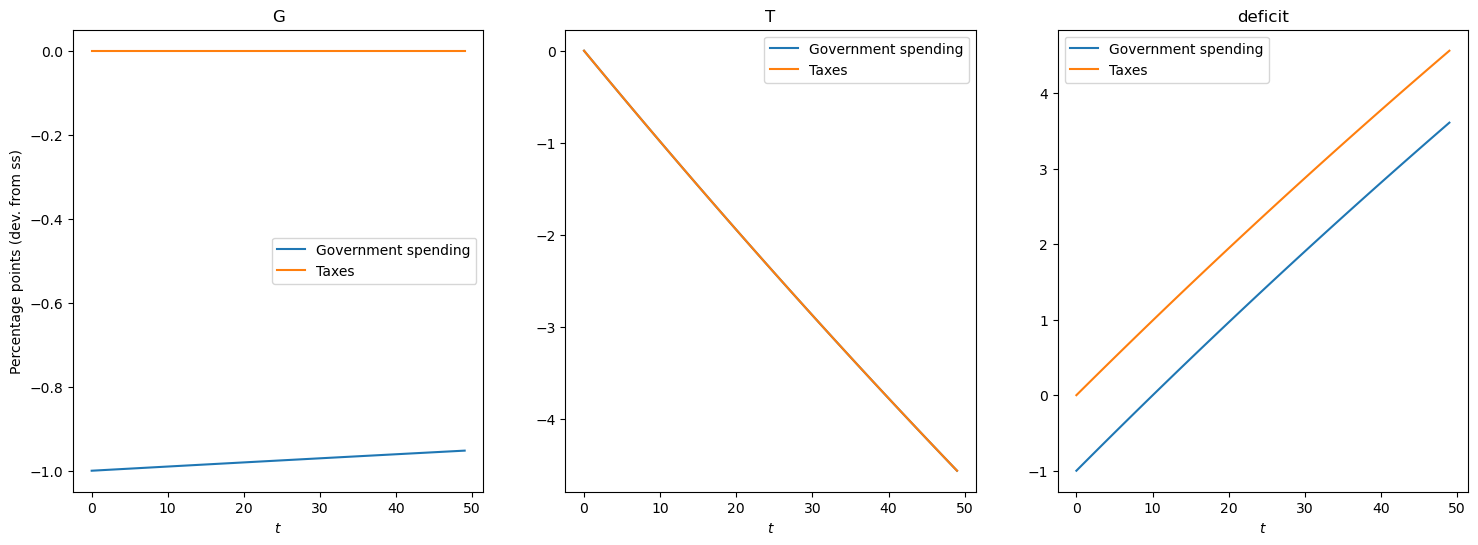

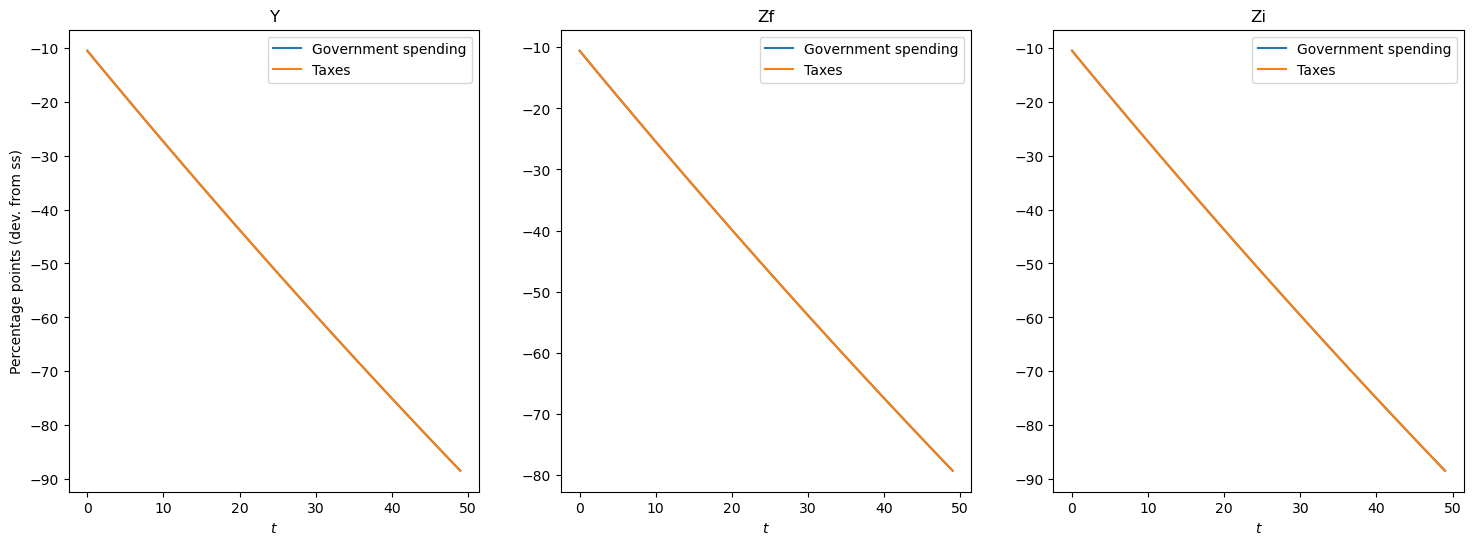

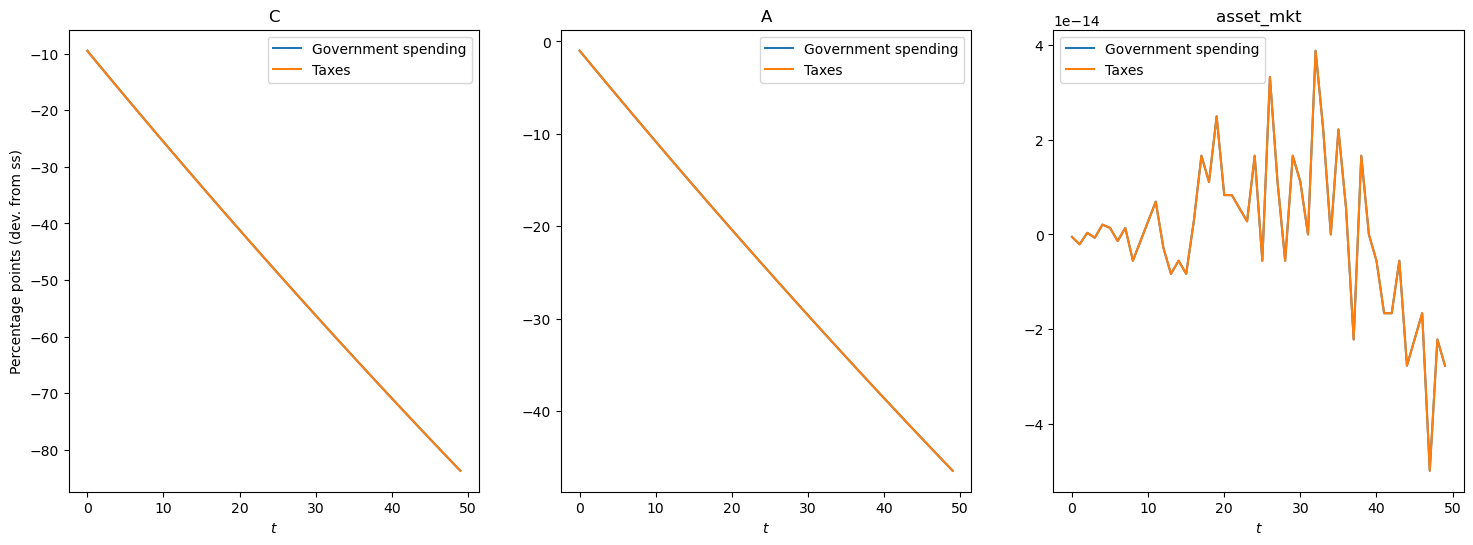

In [ ]:
show_irfs([irfs_B_Perm, irfs_T_Perm], ['G', 'T', 'deficit'], labels=["Government spending", "Taxes"])
show_irfs([irfs_B_Perm, irfs_T_Perm], ['Y', 'Zf', 'Zi'], labels=["Government spending", "Taxes"])
show_irfs([irfs_B_Perm, irfs_T_Perm], ['C', 'A', 'asset_mkt'], labels=["Government spending", "Taxes"])

### Observations
1. Increase in Taxes
- Reduces disposable income of formal sector workers
- GDP decreases which reduces disposable income for everyone
- Formal sector workers are worse off than informal sector workers


2. Reduction in Government Spending
- Reduces GDP
- Reduced GDP decreases disposable income for everyone
- As deficit gets reduced again, taxes for formal sector workers decrease
- Formal sector workers are better off than informal sector workers

3. Comparison to No Labor Mobility
- Drop in output is half as large with labor mobility. Reason is that formal sector workers are more wealthy due to precautionary savings when the risk of moving to the informal sector exists.


